# Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines
## Logistic Regression Model 2

## Introduction
**Research Question: Can you predict whether people got H1N1 and seasonal flu vaccines using information they shared about their backgrounds, opinions, and health behaviors?**

In this challenge, we will take a look at vaccination, a key public health measure used to fight infectious diseases. Vaccines provide immunization for individuals, and enough immunization in a community can further reduce the spread of diseases through "herd immunity."


Our goal is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. Specifically, we'll be predicting two probabilities: one for `h1n1_vaccine` and one for `seasonal_vaccine`.

## About the Data
A vaccine for the H1N1 flu virus became publicly available in October 2009. In late 2009 and early 2010, the United States conducted the National 2009 H1N1 Flu Survey. This phone survey asked respondents whether they had received the H1N1 and seasonal flu vaccines, in conjunction with questions about themselves. These additional questions covered their social, economic, and demographic background, opinions on risks of illness and vaccine effectiveness, and behaviors towards mitigating transmission. A better understanding of how these characteristics are associated with personal vaccination patterns can provide guidance for future public health efforts.

Each row in the dataset represents one person who responded to the National 2009 H1N1 Flu Survey. The dataset includes **35 features**.

For this competition, there are two target variables:

* `h1n1_vaccine` - Whether respondent received H1N1 flu vaccine.
* `seasonal_vaccine` - Whether respondent received seasonal flu vaccine.

Both are binary variables: 0 = No; 1 = Yes. Some respondents didn't get either vaccine, others got only one, and some got both. This is formulated as a multilabel (and not multiclass) problem.

## Helper Functions

In [1]:
def confusion_matrix_plot(conf_matrix, normalize=False, title='Confusion Matrix'):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """  
    if normalize:
        title = 'Normalized Confusion Matrix'
        conf_matrix = np.round(conf_matrix / conf_matrix.sum(axis=1), 2)
        
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)

    plt.tight_layout()
    plt.show()

## Load Packages & Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay

from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow import keras
from keras import metrics

In [3]:
data = pd.read_csv("data/training_set_features.csv")
target = pd.read_csv("data/training_set_labels.csv")

In [4]:
joined_df = data.join(target[['h1n1_vaccine', 'seasonal_vaccine']])
print(joined_df.shape)
joined_df.head()

(26707, 38)


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


## Explore Data

In [5]:
print('Number of zeros:', joined_df[joined_df.seasonal_vaccine == 0].seasonal_vaccine.count())
print('Number of ones:', joined_df[joined_df.seasonal_vaccine == 1].seasonal_vaccine.count())

Number of zeros: 14272
Number of ones: 12435


In [6]:
# How many NAs?
joined_df.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [7]:
joined_df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


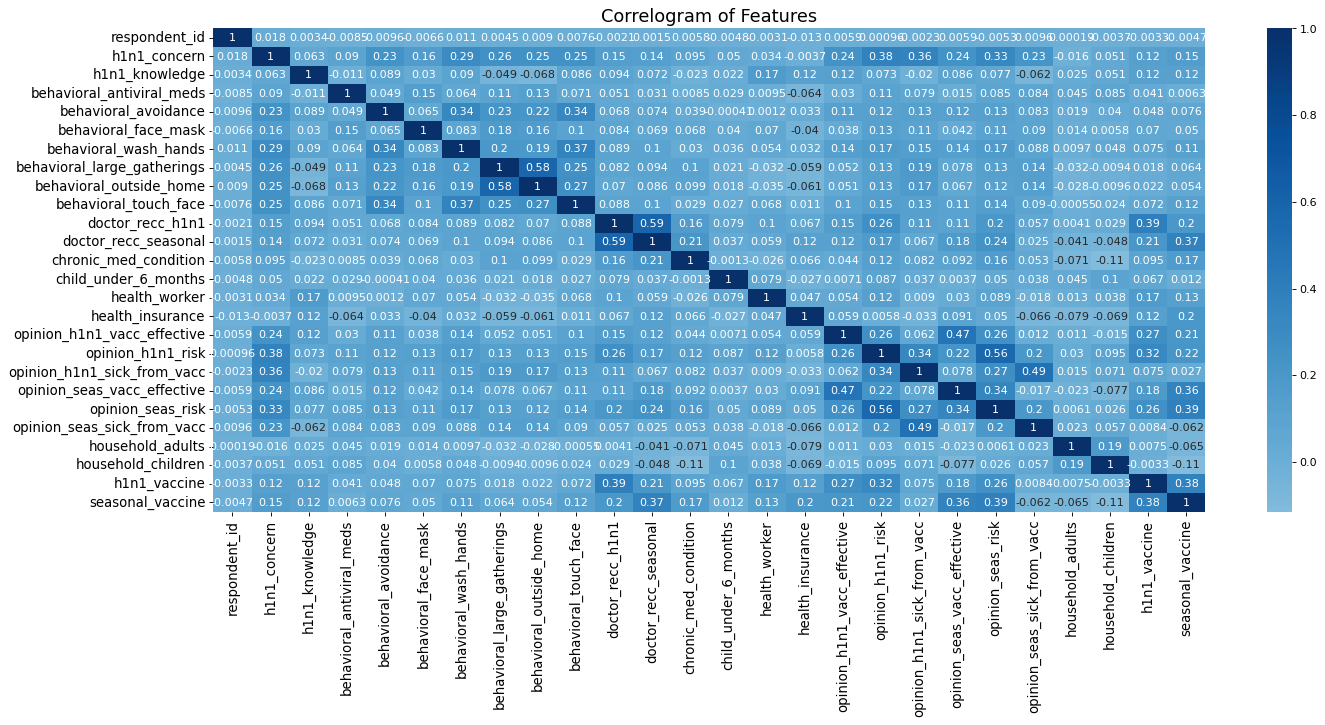

In [8]:
plt.figure(figsize=(20,8), dpi= 80)
sns.heatmap(joined_df.corr(), xticklabels=joined_df.corr().columns, yticklabels=joined_df.corr().columns, cmap='Blues', center=0, annot=True)

# Decorations
plt.title('Correlogram of Features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Looking at the correlation between features and our target `seasonal_vaccine`, we can observe our top 10 most correlated features:
1. opinion_seas_risk - 0.39
2. h1n1_vaccine - 0.38 (however, this is the other target variable)
3. doctor_recc_seasonal - 0.37
4. opinion_seas_vacc_effective - 0.36
5. opinion_h1n1_risk - 0.22
6. opinion_h1n1_vacc_effective - 0.21
7. health_insurance - 0.2
8. doctor_recc_h1n1 - 0.2
9. chronic_med_condition - 0.17
10. h1n1_concern - 0.15
11. health_worker - 0.13

## Feature Engineering

### One-Hot Encoding Columns

In [9]:
## Convert categorical columns to one-hot encodings
age_group_one_hot = pd.get_dummies(joined_df['age_group'])
education_one_hot = pd.get_dummies(joined_df['education'])
race_one_hot = pd.get_dummies(joined_df['race'])
sex_one_hot = pd.get_dummies(joined_df['sex'])
income_poverty_one_hot = pd.get_dummies(joined_df['income_poverty'])
marital_status_one_hot = pd.get_dummies(joined_df['marital_status'])
rent_or_own_one_hot = pd.get_dummies(joined_df['rent_or_own'])
employment_status_one_hot = pd.get_dummies(joined_df['employment_status'])
hhs_geo_region_one_hot = pd.get_dummies(joined_df['hhs_geo_region']).rename(lambda column: f'region_{column}', axis=1)
census_msa_one_hot = pd.get_dummies(joined_df['census_msa'])
employment_industry_one_hot = pd.get_dummies(joined_df['employment_industry']).rename(lambda column: f'industry_{column}', axis=1)
employment_occupation_one_hot = pd.get_dummies(joined_df['employment_occupation']).rename(lambda column: f'occupation_{column}', axis=1)

## Add the new one-hot encoded columns to the dataframe
joined_df = joined_df.join(age_group_one_hot)
joined_df = joined_df.join(education_one_hot)
joined_df = joined_df.join(race_one_hot)
joined_df = joined_df.join(sex_one_hot)
joined_df = joined_df.join(income_poverty_one_hot)
joined_df = joined_df.join(marital_status_one_hot)
joined_df = joined_df.join(rent_or_own_one_hot)
joined_df = joined_df.join(employment_status_one_hot)
joined_df = joined_df.join(hhs_geo_region_one_hot)
joined_df = joined_df.join(census_msa_one_hot)
joined_df = joined_df.join(employment_industry_one_hot)
joined_df = joined_df.join(employment_occupation_one_hot)
joined_df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,occupation_qxajmpny,occupation_rcertsgn,occupation_tfqavkke,occupation_ukymxvdu,occupation_uqqtjvyb,occupation_vlluhbov,occupation_xgwztkwe,occupation_xqwwgdyp,occupation_xtkaffoo,occupation_xzmlyyjv
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


### Pre-Split Feature Engineering

In [10]:
### Set which features should be included - include all numeric columns
features = [x for x in joined_df.select_dtypes(include=[np.number]).columns.tolist() if x != 'seasonal_vaccine' and x != 'respondent_id' and x != 'h1n1_vaccine']

target = ['seasonal_vaccine']
df = joined_df[features + target]

In [11]:
### Handle NAs
print('Old number of rows:', df.shape[0])
print('Number of NAs removed:', sum([True for idx,row in df.iterrows() if any(row.isnull())]))
### Decide how to handle NaN values in df
drop_na = True
df = df.dropna() if drop_na else df.fillna(df.mean())
print('New number of rows:', df.shape[0])

Old number of rows: 26707
Number of NAs removed: 13201
New number of rows: 13506


### Train-Test Split

In [12]:
### Train test split
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2,
                                                    random_state=40)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (10804, 105)
y_train.shape: (10804, 1)
X_test.shape: (2702, 105)
y_test.shape: (2702, 1)


### Post-Split Feature Engineering

In [13]:
### Data Balancing 
# Looks like not needed
y_train.groupby(['seasonal_vaccine']).size()

seasonal_vaccine
0    5393
1    5411
dtype: int64

In [14]:
### Scale & fit features
scaler = StandardScaler()
scaler_model = scaler.fit(X_train)
X_train = scaler_model.transform(X_train)
X_test = scaler_model.transform(X_test)

## First Model

Let's try a logistic regression model with our top 10 correlated features

In [15]:
def build_model(num_features, learning_rate=0.01):
    """Build a TF logistic regression model using Keras.

    Args:
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(1001)
    tf.random.set_seed(1001)

    # Build a model using keras.Sequential.
    model = keras.Sequential()


    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))

    # This layer constructs the linear set of parameters for each input feature
    # (as well as a bias), and applies a sigmoid to the result.
    model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="sigmoid"         # apply the sigmoid function!
    ))

    # Use SGD optimization as per usual.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # We specify the binary_crossentropy loss (equivalent to log loss).
    # Notice that we are including 'binary accuracy' as one of the metrics that we
    # ask Tensorflow to report when evaluating the model.
    model.compile(loss='binary_crossentropy', 
                optimizer=optimizer, 
                metrics=[metrics.binary_accuracy])

    return model

In [16]:
# Build the model
model = build_model(num_features=len(features), learning_rate=0.1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 106       
                                                                 
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________


2022-08-11 12:36:25.832307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
tf.random.set_seed(1001)
np.random.seed(1001)
# Train model
hist= model.fit(x=X_train,
                y=y_train,
                #validation_data=[X_test_std, y_test],
                validation_split=0.1, # set 10% of train data for validation
                batch_size=len(X_train),
                epochs=150,
                verbose=1 #silence fit
)

Epoch 1/150
1/1 [==============================] - 0s 450ms/step - loss: 0.8398 - binary_accuracy: 0.5394 - val_loss: 0.7988 - val_binary_accuracy: 0.5384
Epoch 2/150
1/1 [==============================] - 0s 24ms/step - loss: 0.8052 - binary_accuracy: 0.5562 - val_loss: 0.7694 - val_binary_accuracy: 0.5587
Epoch 3/150
1/1 [==============================] - 0s 26ms/step - loss: 0.7747 - binary_accuracy: 0.5709 - val_loss: 0.7435 - val_binary_accuracy: 0.5698
Epoch 4/150
1/1 [==============================] - 0s 27ms/step - loss: 0.7478 - binary_accuracy: 0.5858 - val_loss: 0.7206 - val_binary_accuracy: 0.5856
Epoch 5/150
1/1 [==============================] - 0s 27ms/step - loss: 0.7240 - binary_accuracy: 0.6009 - val_loss: 0.7004 - val_binary_accuracy: 0.6013
Epoch 6/150
1/1 [==============================] - 0s 27ms/step - loss: 0.7029 - binary_accuracy: 0.6144 - val_loss: 0.6826 - val_binary_accuracy: 0.6087
Epoch 7/150
1/1 [==============================] - 0s 30ms/step - loss: 0.6

Epoch 54/150
1/1 [==============================] - 0s 24ms/step - loss: 0.4818 - binary_accuracy: 0.7795 - val_loss: 0.5011 - val_binary_accuracy: 0.7641
Epoch 55/150
1/1 [==============================] - 0s 26ms/step - loss: 0.4808 - binary_accuracy: 0.7799 - val_loss: 0.5004 - val_binary_accuracy: 0.7641
Epoch 56/150
1/1 [==============================] - 0s 26ms/step - loss: 0.4799 - binary_accuracy: 0.7806 - val_loss: 0.4997 - val_binary_accuracy: 0.7632
Epoch 57/150
1/1 [==============================] - 0s 26ms/step - loss: 0.4790 - binary_accuracy: 0.7811 - val_loss: 0.4990 - val_binary_accuracy: 0.7650
Epoch 58/150
1/1 [==============================] - 0s 25ms/step - loss: 0.4781 - binary_accuracy: 0.7821 - val_loss: 0.4984 - val_binary_accuracy: 0.7650
Epoch 59/150
1/1 [==============================] - 0s 25ms/step - loss: 0.4772 - binary_accuracy: 0.7823 - val_loss: 0.4977 - val_binary_accuracy: 0.7669
Epoch 60/150
1/1 [==============================] - 0s 26ms/step - los

Epoch 107/150
1/1 [==============================] - 0s 26ms/step - loss: 0.4544 - binary_accuracy: 0.7947 - val_loss: 0.4817 - val_binary_accuracy: 0.7771
Epoch 108/150
1/1 [==============================] - 0s 25ms/step - loss: 0.4541 - binary_accuracy: 0.7949 - val_loss: 0.4815 - val_binary_accuracy: 0.7752
Epoch 109/150
1/1 [==============================] - 0s 25ms/step - loss: 0.4539 - binary_accuracy: 0.7951 - val_loss: 0.4814 - val_binary_accuracy: 0.7752
Epoch 110/150
1/1 [==============================] - 0s 26ms/step - loss: 0.4536 - binary_accuracy: 0.7952 - val_loss: 0.4812 - val_binary_accuracy: 0.7752
Epoch 111/150
1/1 [==============================] - 0s 25ms/step - loss: 0.4534 - binary_accuracy: 0.7956 - val_loss: 0.4810 - val_binary_accuracy: 0.7752
Epoch 112/150
1/1 [==============================] - 0s 24ms/step - loss: 0.4531 - binary_accuracy: 0.7956 - val_loss: 0.4809 - val_binary_accuracy: 0.7752
Epoch 113/150
1/1 [==============================] - 0s 25ms/ste

In [18]:
weights = model.get_weights()[0]
feature_weights = [{ "feature": feature, "weight": weights[idx][0] } for (idx, feature) in enumerate(features)]
feature_weights = sorted(feature_weights, key=lambda d: abs(d['weight']), reverse=True) 
feature_weights

[{'feature': 'opinion_seas_risk', 'weight': 0.6179605},
 {'feature': 'opinion_seas_vacc_effective', 'weight': 0.59198296},
 {'feature': 'doctor_recc_seasonal', 'weight': 0.5774877},
 {'feature': '65+ Years', 'weight': 0.40867645},
 {'feature': 'opinion_h1n1_risk', 'weight': 0.26105833},
 {'feature': '18 - 34 Years', 'weight': -0.24342483},
 {'feature': 'health_worker', 'weight': 0.2075221},
 {'feature': 'occupation_dcjcmpih', 'weight': 0.20485058},
 {'feature': 'Black', 'weight': -0.19791752},
 {'feature': 'health_insurance', 'weight': 0.18847793},
 {'feature': 'industry_rucpziij', 'weight': -0.16147873},
 {'feature': '35 - 44 Years', 'weight': -0.16097623},
 {'feature': 'region_lrircsnp', 'weight': -0.1566206},
 {'feature': 'opinion_h1n1_sick_from_vacc', 'weight': -0.15482622},
 {'feature': 'College Graduate', 'weight': 0.1325861},
 {'feature': 'opinion_seas_sick_from_vacc', 'weight': -0.12484053},
 {'feature': 'Rent', 'weight': -0.12208732},
 {'feature': 'region_bhuqouqj', 'weight': 

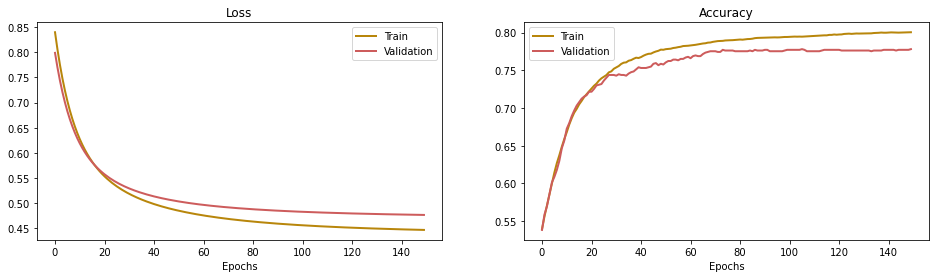

In [19]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 2, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

In [20]:
# Predict on train and test
train_predictions = model.predict(x=X_train)
test_predictions = model.predict(x=X_test)

85/85 [==============================] - 0s 838us/step


In [21]:
# Threshold
train_predictions = np.where(train_predictions >= 0.5, 1, 0)
test_predictions = np.where(test_predictions >= 0.5, 1, 0)

## Evaluation

In [22]:
# Compare the first 10 predictions
test_compare = y_test.copy()
test_compare['prediction'] = test_predictions
test_compare.rename(columns={"seasonal_vaccine": "label"}, inplace=True)
test_compare.head(10)

,label,prediction
14099,1,1
11915,0,0
1819,0,0
9740,0,1
19651,0,0
20986,0,0
17724,1,1
19695,0,1
3072,0,0
8198,0,0


### Train Evaluation

In [23]:
print('Area Under ROC:', round(roc_auc_score(y_train, train_predictions), 4))
print('Accuracy:', round(accuracy_score(y_train, train_predictions), 4))
print('Precision:', round(precision_score(y_train, train_predictions), 4))
print('Recall:', round(recall_score(y_train, train_predictions), 4))
print('F1 Score:', round(f1_score(y_train, train_predictions), 4))

Area Under ROC: 0.7983
Accuracy: 0.7983
Precision: 0.8017
Recall: 0.7936
F1 Score: 0.7976


### Test Evaluation

In [24]:
print('Area Under ROC:', round(roc_auc_score(y_test, test_predictions), 4))
print('Accuracy:', round(accuracy_score(y_test, test_predictions), 4))
print('Precision:', round(precision_score(y_test, test_predictions), 4))
print('Recall:', round(recall_score(y_test, test_predictions), 4))
print('F1 Score:', round(f1_score(y_test, test_predictions), 4))

Area Under ROC: 0.8045
Accuracy: 0.8042
Precision: 0.8197
Recall: 0.7944
F1 Score: 0.8069


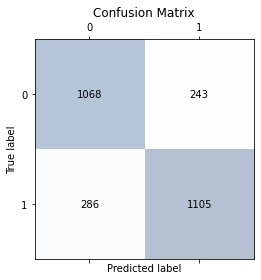

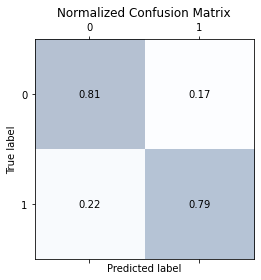

In [25]:
conf_matrix = tf.math.confusion_matrix(
    y_test,
    test_predictions.flatten(),
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix

confusion_matrix_plot(conf_matrix.numpy())
confusion_matrix_plot(conf_matrix.numpy(), normalize=True)

## Hyperparameter Tuning

| Training accuracy | Validation accuracy | ROC  | F1 Score  | Optimizer | Learning Rate | NaN        | Activation | Epochs
|:-:                |:-:                  |:-:   |:-:         |:-:        |:-:            |:-:         |:-: |:-:
| 0.7941            | 0.7771              | 0.7934 | 0.7958 | SGD        | 0.1           | Dropped    | Sigmoid | 100
| 0.8004            | 0.7780              | 0.8045 | 0.8069 | SGD        | 0.1           | Dropped    | Sigmoid | 150
| 0.8019            | 0.7761              | 0.8027 | 0.8048 | SGD        | 0.1           | Dropped    | Sigmoid | 200
| 0.8029            | 0.7826              | 0.8030 | 0.8057 | SGD        | 0.1           | Dropped    | Sigmoid | 300
| 0.8018            | 0.7761              | 0.8001 | 0.8022 | Adam        | 0.01           | Dropped    | Sigmoid | 50

## Full Model Training
Train using all available data for best model performance.

In [26]:
x_train_full = df[features]
y_train_full = df[target]

In [27]:
print(len(x_train_full))
print(len(y_train_full))
x_train_full.head()

13506
13506


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,occupation_qxajmpny,occupation_rcertsgn,occupation_tfqavkke,occupation_ukymxvdu,occupation_uqqtjvyb,occupation_vlluhbov,occupation_xgwztkwe,occupation_xqwwgdyp,occupation_xtkaffoo,occupation_xzmlyyjv
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
9,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
10,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [28]:
final_model = build_model(num_features=len(features), learning_rate=0.1)
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 106       
                                                                 
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________


In [29]:
hist = final_model.fit(x=x_train_full,
                y=y_train_full,
                #validation_data=[X_test_std, y_test],
                validation_split=0.1, # set 10% of train data for validation
                batch_size=len(x_train_full),
                epochs=200,
                verbose=1 #silence fit
)

Epoch 1/200
1/1 [==============================] - 0s 411ms/step - loss: 0.7311 - binary_accuracy: 0.5174 - val_loss: 0.7219 - val_binary_accuracy: 0.5144
Epoch 2/200
1/1 [==============================] - 0s 29ms/step - loss: 0.7194 - binary_accuracy: 0.5216 - val_loss: 0.7113 - val_binary_accuracy: 0.5344
Epoch 3/200
1/1 [==============================] - 0s 27ms/step - loss: 0.7086 - binary_accuracy: 0.5390 - val_loss: 0.7017 - val_binary_accuracy: 0.5485
Epoch 4/200
1/1 [==============================] - 0s 26ms/step - loss: 0.6986 - binary_accuracy: 0.5493 - val_loss: 0.6926 - val_binary_accuracy: 0.5603
Epoch 5/200
1/1 [==============================] - 0s 30ms/step - loss: 0.6892 - binary_accuracy: 0.5617 - val_loss: 0.6841 - val_binary_accuracy: 0.5714
Epoch 6/200
1/1 [==============================] - 0s 31ms/step - loss: 0.6805 - binary_accuracy: 0.5729 - val_loss: 0.6761 - val_binary_accuracy: 0.5840
Epoch 7/200
1/1 [==============================] - 0s 33ms/step - loss: 0.6

Epoch 54/200
1/1 [==============================] - 0s 29ms/step - loss: 0.5339 - binary_accuracy: 0.7476 - val_loss: 0.5439 - val_binary_accuracy: 0.7358
Epoch 55/200
1/1 [==============================] - 0s 30ms/step - loss: 0.5329 - binary_accuracy: 0.7482 - val_loss: 0.5430 - val_binary_accuracy: 0.7358
Epoch 56/200
1/1 [==============================] - 0s 30ms/step - loss: 0.5319 - binary_accuracy: 0.7487 - val_loss: 0.5422 - val_binary_accuracy: 0.7365
Epoch 57/200
1/1 [==============================] - 0s 31ms/step - loss: 0.5310 - binary_accuracy: 0.7495 - val_loss: 0.5413 - val_binary_accuracy: 0.7372
Epoch 58/200
1/1 [==============================] - 0s 32ms/step - loss: 0.5301 - binary_accuracy: 0.7503 - val_loss: 0.5405 - val_binary_accuracy: 0.7387
Epoch 59/200
1/1 [==============================] - 0s 30ms/step - loss: 0.5292 - binary_accuracy: 0.7506 - val_loss: 0.5397 - val_binary_accuracy: 0.7402
Epoch 60/200
1/1 [==============================] - 0s 29ms/step - los

Epoch 107/200
1/1 [==============================] - 0s 29ms/step - loss: 0.5031 - binary_accuracy: 0.7666 - val_loss: 0.5166 - val_binary_accuracy: 0.7676
Epoch 108/200
1/1 [==============================] - 0s 28ms/step - loss: 0.5028 - binary_accuracy: 0.7669 - val_loss: 0.5163 - val_binary_accuracy: 0.7683
Epoch 109/200
1/1 [==============================] - 0s 30ms/step - loss: 0.5024 - binary_accuracy: 0.7673 - val_loss: 0.5160 - val_binary_accuracy: 0.7683
Epoch 110/200
1/1 [==============================] - 0s 28ms/step - loss: 0.5021 - binary_accuracy: 0.7675 - val_loss: 0.5157 - val_binary_accuracy: 0.7676
Epoch 111/200
1/1 [==============================] - 0s 29ms/step - loss: 0.5018 - binary_accuracy: 0.7676 - val_loss: 0.5154 - val_binary_accuracy: 0.7676
Epoch 112/200
1/1 [==============================] - 0s 28ms/step - loss: 0.5015 - binary_accuracy: 0.7678 - val_loss: 0.5152 - val_binary_accuracy: 0.7676
Epoch 113/200
1/1 [==============================] - 0s 28ms/ste

1/1 [==============================] - 0s 30ms/step - loss: 0.4901 - binary_accuracy: 0.7765 - val_loss: 0.5050 - val_binary_accuracy: 0.7735
Epoch 160/200
1/1 [==============================] - 0s 30ms/step - loss: 0.4899 - binary_accuracy: 0.7767 - val_loss: 0.5048 - val_binary_accuracy: 0.7735
Epoch 161/200
1/1 [==============================] - 0s 28ms/step - loss: 0.4898 - binary_accuracy: 0.7769 - val_loss: 0.5047 - val_binary_accuracy: 0.7735
Epoch 162/200
1/1 [==============================] - 0s 27ms/step - loss: 0.4896 - binary_accuracy: 0.7769 - val_loss: 0.5045 - val_binary_accuracy: 0.7735
Epoch 163/200
1/1 [==============================] - 0s 27ms/step - loss: 0.4894 - binary_accuracy: 0.7772 - val_loss: 0.5043 - val_binary_accuracy: 0.7735
Epoch 164/200
1/1 [==============================] - 0s 30ms/step - loss: 0.4892 - binary_accuracy: 0.7771 - val_loss: 0.5042 - val_binary_accuracy: 0.7735
Epoch 165/200
1/1 [==============================] - 0s 29ms/step - loss: 0.48

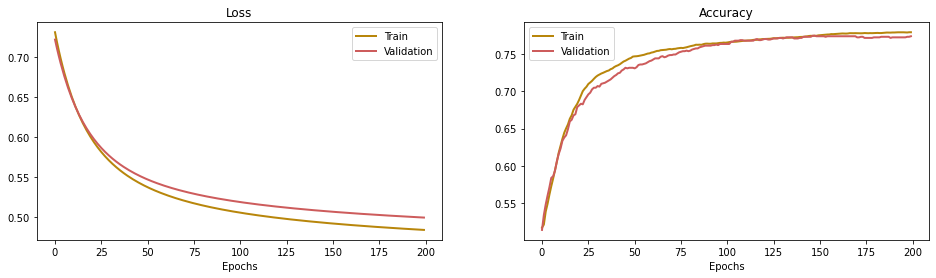

In [30]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 2, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

## Prepare Test Data
Perform the same feature engineering as training and handle NaN values by inserting the mean.

In [31]:
x_test_full = pd.read_csv('./data/test_set_features.csv')

In [32]:
## Convert categorical columns to one-hot encodings
age_group_test_one_hot = pd.get_dummies(x_test_full['age_group'])
education_test_one_hot = pd.get_dummies(x_test_full['education'])
race_test_one_hot = pd.get_dummies(x_test_full['race'])
sex_test_one_hot = pd.get_dummies(x_test_full['sex'])
income_poverty_test_one_hot = pd.get_dummies(x_test_full['income_poverty'])
marital_status_test_one_hot = pd.get_dummies(x_test_full['marital_status'])
rent_or_own_test_one_hot = pd.get_dummies(x_test_full['rent_or_own'])
employment_status_test_one_hot = pd.get_dummies(x_test_full['employment_status'])
hhs_geo_region_test_one_hot = pd.get_dummies(x_test_full['hhs_geo_region']).rename(lambda column: f'region_{column}', axis=1)
census_msa_test_one_hot = pd.get_dummies(x_test_full['census_msa'])
employment_industry_test_one_hot = pd.get_dummies(x_test_full['employment_industry']).rename(lambda column: f'industry_{column}', axis=1)
employment_occupation_test_one_hot = pd.get_dummies(x_test_full['employment_occupation']).rename(lambda column: f'occupation_{column}', axis=1)

## Add the new one-hot encoded columns to the dataframe
x_test_full = x_test_full.join(age_group_test_one_hot)
x_test_full = x_test_full.join(education_test_one_hot)
x_test_full = x_test_full.join(race_test_one_hot)
x_test_full = x_test_full.join(sex_test_one_hot)
x_test_full = x_test_full.join(income_poverty_test_one_hot)
x_test_full = x_test_full.join(marital_status_test_one_hot)
x_test_full = x_test_full.join(rent_or_own_test_one_hot)
x_test_full = x_test_full.join(employment_status_test_one_hot)
x_test_full = x_test_full.join(hhs_geo_region_test_one_hot)
x_test_full = x_test_full.join(census_msa_test_one_hot)
x_test_full = x_test_full.join(employment_industry_test_one_hot)
x_test_full = x_test_full.join(employment_occupation_test_one_hot)
x_test_full.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,occupation_qxajmpny,occupation_rcertsgn,occupation_tfqavkke,occupation_ukymxvdu,occupation_uqqtjvyb,occupation_vlluhbov,occupation_xgwztkwe,occupation_xqwwgdyp,occupation_xtkaffoo,occupation_xzmlyyjv
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
## Use same features as in training
test_df = x_test_full[features]
test_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,occupation_qxajmpny,occupation_rcertsgn,occupation_tfqavkke,occupation_ukymxvdu,occupation_uqqtjvyb,occupation_vlluhbov,occupation_xgwztkwe,occupation_xqwwgdyp,occupation_xtkaffoo,occupation_xzmlyyjv
0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
## Set each null value to the mean for the column. This is needed because we can't drop test examples with NaN.
test_df = test_df.fillna(test_df.mean())
test_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,occupation_qxajmpny,occupation_rcertsgn,occupation_tfqavkke,occupation_ukymxvdu,occupation_uqqtjvyb,occupation_vlluhbov,occupation_xgwztkwe,occupation_xqwwgdyp,occupation_xtkaffoo,occupation_xzmlyyjv
0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
final_model.predict(x=test_df)

835/835 [==============================] - 1s 773us/step


array([[0.25477126],
       [0.05561005],
       [0.55919343],
       ...,
       [0.46081108],
       [0.61567307],
       [0.65247387]], dtype=float32)

In [36]:
test_df['prediction'] = final_test_predictions

In [37]:
test_df[['prediction', 'opinion_seas_risk', 'opinion_seas_vacc_effective', 'doctor_recc_seasonal', '65+ Years']]

,prediction,opinion_seas_risk,opinion_seas_vacc_effective,doctor_recc_seasonal,65+ Years
0,0.986078,1.0,5.0,0.0,0
1,0.939548,1.0,4.0,0.0,0
2,0.998618,4.0,5.0,0.0,0
3,0.998119,4.0,4.0,1.0,1
4,0.994298,4.0,4.0,0.0,0
...,...,...,...,...,...
26703,0.990780,2.0,4.0,1.0,0
26704,0.988825,2.0,5.0,0.0,0
26705,0.992147,3.0,4.0,0.0,0
26706,0.990063,3.0,4.0,0.0,0


In [38]:
predictions_df = pd.DataFrame(final_test_predictions, columns=['seasonal_flu_prediction'])

In [48]:
predictions_df

,seasonal_flu_prediction
0,0.986078
1,0.939548
2,0.998618
3,0.998119
4,0.994298
...,...
26703,0.990780
26704,0.988825
26705,0.992147
26706,0.990063


In [39]:
predictions_df.to_csv('seasonal_flu_predictions.csv')